In [1]:
import numpy as np
from pandas import crosstab
from matplotlib import pyplot as plt

def safelog2(x):
    if x == 0:
        return (0)
    else:
        return np.log2(x)

In [2]:
data = np.genfromtxt("dataset.csv", delimiter = ",",skip_header = 1)

x_train = data[:150, 0]
y_train = data[:150, 1].astype(int)

x_test = data[150:, 0]
y_test = data[150:, 1].astype(int)

N_train = len(y_train)
N_test = len(y_test)

In [3]:
def decision_tree_regression(P):
    node_indices = {}
    is_terminal = {}
    need_split = {}

    node_splits = {}
    node_predictions = {}

    node_indices[1] = np.array(range(N_train))
    is_terminal[1] = False
    need_split[1] = True

    while True:
        split_nodes = [key for key, value in need_split.items() if value == True]

        if len(split_nodes) == 0:
            break

        for split_node in split_nodes:
            data_indices = node_indices[split_node]

            need_split[split_node] = False
            is_terminal[split_node] = False

            unique_values = np.sort(np.unique(x_train[data_indices]))
            split_positions = (unique_values[:-1] + unique_values[1:]) / 2
            split_scores = np.repeat(0.0, len(split_positions))

            for s in range(len(split_positions)):
                left_indices = data_indices[x_train[data_indices] <= split_positions[s]]
                right_indices = data_indices[x_train[data_indices] > split_positions[s]]
                split_scores[s] = (1/len(data_indices))*(np.sum((y_train[left_indices] - np.mean(y_train[left_indices]))**2) + 
                                                         np.sum((y_train[right_indices] - np.mean(y_train[right_indices]))**2))
            best_score = np.min(split_scores)
            best_split = split_positions[np.argmin(split_scores)]

            node_splits[split_node] = best_split

            # create left node using the selected split
            left_indices = data_indices[x_train[data_indices] <= best_split]
            node_indices[2 * split_node] = left_indices
            if len(node_indices[2 * split_node]) <= P:
                node_predictions[2 * split_node] = np.mean(y_train[left_indices])
                is_terminal[2 * split_node] = True
                need_split[2 * split_node] = False
            else:
                is_terminal[2 * split_node] = False
                need_split[2 * split_node] = True

            # create right node using the selected split
            right_indices = data_indices[x_train[data_indices] > best_split]
            node_indices[2 * split_node + 1] = right_indices
            if len(node_indices[2 * split_node + 1]) <= P:
                node_predictions[2 * split_node + 1] = np.mean(y_train[right_indices])
                is_terminal[2 * split_node + 1] = True
                need_split[2 * split_node + 1] = False
            else:
                is_terminal[2 * split_node + 1] = False
                need_split[2 * split_node + 1] = True
                
    return is_terminal, node_splits, node_predictions

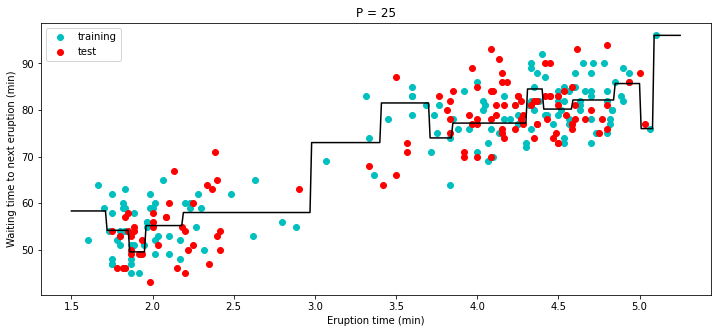

In [4]:
P = 25

is_terminal, node_splits, node_predictions = decision_tree_regression(P)
data_interval = np.linspace(1.5, 5.25, 376)
y_graph = np.repeat(0.0 , len(data_interval))

for i in range(len(data_interval)):
    index = 1
    while True:
        if is_terminal[index] == True:
            y_graph[i] = node_predictions[index]
            break
        else:
            if data_interval[i] <= node_splits[index]:
                index = index * 2
            else:
                index = index * 2 + 1

plt.figure(figsize = (12, 5))
plt.plot(x_train, y_train, "co", label = "training")
plt.plot(x_test, y_test, "ro", label = "test")
plt.plot(data_interval, y_graph, "k")
plt.title(f"P = {25}")
plt.xlabel('Eruption time (min)')
plt.ylabel('Waiting time to next eruption (min)')
plt.legend()
plt.show()

In [5]:
y_predicted = np.repeat(0.0 , len(y_test))

for i in range(len(y_test)):
    index = 1
    while True:
        if is_terminal[index] == True:
            y_predicted[i] = node_predictions[index]
            break
        else:
            if x_test[i] <= node_splits[index]:
                index = index * 2
            else:
                index = index * 2 + 1

In [6]:
RMSE = np.round(np.sqrt(np.mean((y_test - y_predicted)**2)), 4)

In [7]:
print(f"RMSE is {RMSE} when P is {P}")

RMSE is 6.4541 when P is 25


In [8]:
RMSE_values = {}
for P in np.linspace(5 , 50, 10):
    is_terminal, node_splits, node_predictions = decision_tree_regression(P)
    
    y_predicted = np.repeat(0.0 , len(y_test))

    for i in range(len(y_test)):
        index = 1
        while True:
            if is_terminal[index] == True:
                y_predicted[i] = node_predictions[index]
                break
            else:
                if x_test[i] <= node_splits[index]:
                    index = index * 2
                else:
                    index = index * 2 + 1
    RMSE = np.round(np.sqrt(np.mean((y_test - y_predicted)**2)), 4)
    
    RMSE_values[P] = RMSE

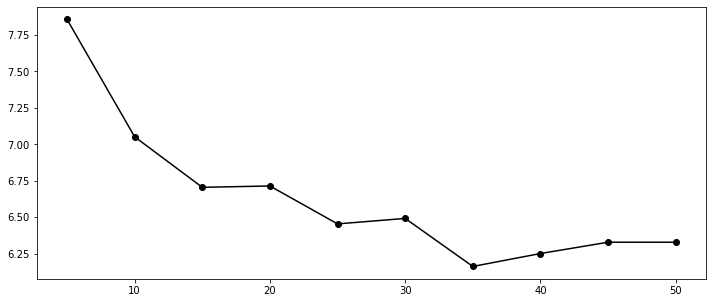

In [9]:
plt.figure(figsize = (12, 5))
plt.plot(RMSE_values.keys(), RMSE_values.values(), "k-o")